# Stochastic fluid model with out recourse

In [11]:
from numpy import *
import random
import numpy as np
from gurobipy import *
import time
import matplotlib.pyplot as plt

In [12]:
# function use to record the model computing performence
def running_time_record(model,eps):
    #input model name and the tolerence level
    start = time.time()
    model(eps)
    end = time.time()
    return str(end-start)

In [13]:
# function use to record the model computing performence by monte carlo method
def time_record_monte(model,eps,size):
    time_1=np.zeros(50)
    for n in range(50):        
        start = time.time()
        model(eps,size)
        end = time.time()
        time_1[n] = str(end-start)
    time_average=np.sum(time_1)/50
    return time_average

In [14]:
# function use to record the iteration time by monte carlo method
def iteration_record(model,eps,size):
    k_1=np.zeros(50)
    for n in range(50):        
        k_1[n]=model(eps,size)
    k_average=np.sum(k_1)/50
    return k_average

## random alpha (4-2 buffers-stations)

In [15]:
scenario=2
K=4
J=2
#alpha1=np.random.uniform(0, 0.3, 1000)
alpha1=[0.1,0.2]
#alpha1=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alpha=np.transpose([[i,0.0,0.0,0.0] for i in alpha1])
a=[10.0, 10.0, 10.0, 10.0]
C=[[1.0,0.0,1.0,0.0],
   [0.0,1.0,0.0,1.0]]
P=[[0.0,1.0,0.0,0.0],
    [0.0,0.0,1.0,0.0],
    [0.0,0.0,0.0,1.0],
    [0.0,0.0,0.0,0.0]]
I=np.eye(K)
M=[0.3,0.3,0.5,0.2]
Q=np.linalg.inv(I-np.transpose(P))
Qalpha=np.matmul(Q,alpha)
Qalpham=[Qalpha[i]*M[i] for i in range(K)]
max_Qalpham = np.amax(Qalpham, 1)
Qa=np.matmul(Q,a)
Qam=[Qa[i]*M[i] for i in range(K)]

In [16]:
def ms_alpha(eps):
    ms_1 = Model("ms_1")
    theta = ms_1.addVar(lb=0,name='theta')
    v = ms_1.addVars(K,lb=0,name='v')    

    ms_1.addConstrs((v[j] >= max_Qalpham[j]+0.0001 for j in range(K)),name='vk')
    ms_1.addConstrs(((quicksum([np.dot(C[i][j],v[j]) for j in range(K)])) <= 1 for i in range(J)),name='cap')
    ms_1.setObjective(theta, GRB.MINIMIZE)
    ms_1.update()
    ms_1.optimize()
    
    z_up = 10000000000
    z_low = 0
    #obj=[]
    k=0
    while z_up - z_low > eps:
        ms_1.update()
        ms_1.optimize()
        ms_1.write("out.lp")
        obj=[]
        # Set objective function
        obj.append(ms_1.objVal)
        #n=len(obj)
        #print("obj",obj)
        v_0=ms_1.getAttr("X")[1:]
        theta_0=ms_1.getAttr("X")[0]
        #print("v_0",v_0)
        #print("theta_0",theta_0)
        
        ms = np.zeros((scenario,K))
        ms_system = np.zeros(scenario)
        for i in range(scenario):
            ms[i] =  np.array(Qam)/ np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i]
            #print("ms",ms)
            ms_system[i] = max(ms[i][j] for j in range(K))
            #print("ms_system",ms_system)
        ms_average = sum(ms_system)/scenario
        #print("ms_average",ms_average)
        
        z_low = theta_0
        if z_up > ms_average:
            z_up = ms_average
            
        else:
            z_up = z_up
        print("z_up",z_up)
        print("z_low",z_low)
        Gradient = np.zeros((scenario,K))
        Gradient_average = np.zeros(K)
        for i in range(scenario):
            max_index = np.argmax((ms[i]))
            #print("Qam[max_index]",np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2)
            Gradient[i][max_index] = -Qam[max_index]/np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2
            #print("Gradient",Gradient)
        Gradient_average = np.sum(Gradient,axis=0)/scenario
        #print("Gradient_average",Gradient_average)
        #print("dot",np.dot(Gradient_average,v_0))
        ms_1.addConstr((theta>=ms_average-np.dot(Gradient_average,v_0)+quicksum([np.dot(Gradient_average[j],v[j]) for j in range(K)])),name='feasible_cut')
        ms_1.update()
        k=k+1
    else:
        ms_1.optimize()
        ms_1.printAttr('X')
        #cons=ms_1.getConstrs()
    return("the total number of iteration is:",k)

## random a (4-2 buffers-stations)

In [17]:
scenario=2
K=4
J=2
alpha=np.transpose([0.5,0.0,0.0,0.0])
a=np.transpose([[10.0, 20.0, 10.0, 20.0],[20.0, 10.0, 20.0, 10.0]])
C=[[1.0,0.0,1.0,0.0],
   [0.0,1.0,0.0,1.0]]
P=[[0.0,1.0,0.0,0.0],
    [0.0,0.0,1.0,0.0],
    [0.0,0.0,0.0,1.0],
    [0.0,0.0,0.0,0.0]]
I=np.eye(K)
M=[0.3,0.3,0.5,0.2]

Q=np.linalg.inv(I-np.transpose(P))
Qalpha=np.matmul(Q,alpha)
Qalpham=Qalpha*M
Qa=np.matmul(Q,a)
Qam=[Qa[i]*M[i] for i in range(K)]

In [18]:
def ms_a(eps):
    ms_1 = Model("ms_1")
    theta = ms_1.addVar(lb=0,name='theta')
    v = ms_1.addVars(K,lb=0,name='v')    

    ms_1.addConstrs((v[j] >= Qalpham[j]+0.0001 for j in range(K)),name='vk')
    ms_1.addConstrs(((quicksum([np.dot(C[i][j],v[j]) for j in range(K)])) <= 1 for i in range(J)),name='cap')
    ms_1.setObjective(theta, GRB.MINIMIZE)
    ms_1.update()
    ms_1.optimize()
    
    z_up = 10000000000
    z_low = 0
    #obj=[]
    k=0
    while z_up - z_low > eps:
        ms_1.update()
        ms_1.optimize()
        ms_1.write("out.lp")
        obj=[]
        # Set objective function
        obj.append(ms_1.objVal)
        #n=len(obj)
        print("obj",obj)
        v_0=ms_1.getAttr("X")[1:]
        theta_0=ms_1.getAttr("X")[0]
        print("v_0",v_0)
        print("theta_0",theta_0)
        
        ms = np.zeros((scenario,K))
        ms_system = np.zeros(scenario)
        for i in range(scenario):
            ms[i] =  np.transpose(Qam)[i]/ np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))
            #print("ms",ms)
            ms_system[i] = max(ms[i][j] for j in range(K))
            #print("ms_system",ms_system)
        ms_average = sum(ms_system)/scenario
        #print("ms_average",ms_average)
        
        z_low = theta_0
        if z_up > ms_average:
            z_up = ms_average
            
        else:
            z_up = z_up
        print("z_up",z_up)
        print("z_low",z_low)
        Gradient = np.zeros((scenario,K))
        Gradient_average = np.zeros(K)
        for i in range(scenario):
            max_index = np.argmax((ms[i]))
            #print("Qam[max_index]",np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2)
            Gradient[i][max_index] = -np.transpose(Qam)[i][max_index]/np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[max_index]**2
            #print("Gradient",Gradient)
        Gradient_average = np.sum(Gradient,axis=0)/scenario
        print("Gradient_average",Gradient_average)
        #print("dot",np.dot(Gradient_average,v_0))
        ms_1.addConstr((theta>=ms_average-np.dot(Gradient_average,v_0)+quicksum([np.dot(Gradient_average[j],v[j]) for j in range(K)])),name='feasible_cut')
        ms_1.update()
        k=k+1
    else:
        ms_1.optimize()
        ms_1.printAttr('X')
    print("the total number of iteration is:",k)

## random m (4-2 buffers-stations)

In [19]:
scenario=2
K=4
J=2
alpha=np.transpose([0.15,0.0,0.0,0.0])
a=np.transpose([10.0, 10.0, 10.0, 10.0])
C=[[1.0,0.0,1.0,0.0],
   [0.0,1.0,0.0,1.0]]
P=[[0.0,1.0,0.0,0.0],
    [0.0,0.0,1.0,0.0],
    [0.0,0.0,0.0,1.0],
    [0.0,0.0,0.0,0.0]]
I=np.eye(K)
M=[[0.3,0.3,0.5,0.2],[0.3,0.5,0.2,0.3]]

Q=np.linalg.inv(I-np.transpose(P))
Qalpha=np.matmul(Q,alpha)
Qalpham=np.transpose(Qalpha*M)
Qa=np.matmul(Q,a)
Qam = np.zeros((scenario,K))
for i in range (scenario):
    Qam[i]=[Qa[j]*M[i][j] for j in range(K)]
max_Qalpham = np.amax(Qalpham, 1)

In [20]:
def ms_m(eps):
    ms_1 = Model("ms_1")
    theta = ms_1.addVar(lb=0,name='theta')
    v = ms_1.addVars(K,lb=0,name='v')    

    ms_1.addConstrs((v[j] >= max_Qalpham[j]+0.0001 for j in range(K)),name='vk')
    ms_1.addConstrs(((quicksum([np.dot(C[i][j],v[j]) for j in range(K)])) <= 1 for i in range(J)),name='cap')
    ms_1.setObjective(theta, GRB.MINIMIZE)
    ms_1.update()
    ms_1.optimize()
    
    z_up = 10000000000
    z_low = 0
    #obj=[]
    k=0
    while z_up - z_low > eps:
        ms_1.update()
        ms_1.optimize()
        ms_1.write("out.lp")
        obj=[]
        # Set objective function
        obj.append(ms_1.objVal)
        #n=len(obj)
        print("obj",obj)
        v_0=ms_1.getAttr("X")[1:]
        theta_0=ms_1.getAttr("X")[0]
        print("v_0",v_0)
        print("theta_0",theta_0)
        
        ms = np.zeros((scenario,K))
        ms_system = np.zeros(scenario)
        for i in range(scenario):
            ms[i] =   np.transpose(Qam[i])/ np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i]
            #print("ms",ms)
            ms_system[i] = max(ms[i][j] for j in range(K))
            #print("ms_system",ms_system)
        ms_average = sum(ms_system)/scenario
        #print("ms_average",ms_average)
        
        z_low = theta_0
        if z_up > ms_average:
            z_up = ms_average
            
        else:
            z_up = z_up
        print("z_up",z_up)
        print("z_low",z_low)
        Gradient = np.zeros((scenario,K))
        Gradient_average = np.zeros(K)
        for i in range(scenario):
            max_index = np.argmax((ms[i]))
            #print("Qam[max_index]",np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2)
            Gradient[i][max_index] = -Qam[i][max_index]/np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2
            #print("Gradient",Gradient)
        Gradient_average = np.sum(Gradient,axis=0)/scenario
        print("Gradient_average",Gradient_average)
        #print("dot",np.dot(Gradient_average,v_0))
        ms_1.addConstr((theta>=ms_average-np.dot(Gradient_average,v_0)+quicksum([np.dot(Gradient_average[j],v[j]) for j in range(K)])),name='feasible_cut')
        ms_1.update()
        k=k+1
    else:
        ms_1.optimize()
        ms_1.printAttr('X')
    print("the total number of iteration is:",k)
    

## random alpha with n scenario(4-2 buffers-stations)

In [21]:
def ms_a_ns(eps,scenario):
    K=4
    J=2
    alpha1=np.random.uniform(0, 1, scenario)
    alpha=np.transpose([[i,0.0,0.0,0.0] for i in alpha1])
    a=[10.0, 10.0, 10.0, 10.0]
    C=[[1.0,0.0,1.0,0.0],
       [0.0,1.0,0.0,1.0]]
    P=[[0.0,1.0,0.0,0.0],
        [0.0,0.0,1.0,0.0],
        [0.0,0.0,0.0,1.0],
        [0.0,0.0,0.0,0.0]]
    I=np.eye(K)
    M=[0.3,0.3,0.5,0.2]
    Q=np.linalg.inv(I-np.transpose(P))
    Qalpha=np.matmul(Q,alpha)
    Qalpham=[Qalpha[i]*M[i] for i in range(K)]
    max_Qalpham = np.amax(Qalpham, 1)
    Qa=np.matmul(Q,a)
    Qam=[Qa[i]*M[i] for i in range(K)]
    
    ms_1 = Model("ms_1")
    theta = ms_1.addVar(lb=0,name='theta')
    v = ms_1.addVars(K,lb=0,name='v')    

    ms_1.addConstrs((v[j] >= max_Qalpham[j]+0.0001 for j in range(K)),name='vk')
    ms_1.addConstrs(((quicksum([np.dot(C[i][j],v[j]) for j in range(K)])) <= 1 for i in range(J)),name='cap')
    ms_1.setObjective(theta, GRB.MINIMIZE)
    ms_1.update()
    ms_1.optimize()
    
    z_up = 10000000000
    z_low = 0
    #obj=[]
    k=0
    while z_up - z_low > eps:
        ms_1.update()
        ms_1.optimize()
        ms_1.write("out.lp")
        obj=[]
        # Set objective function
        obj.append(ms_1.objVal)
        #n=len(obj)
        #print("obj",obj)
        v_0=ms_1.getAttr("X")[1:]
        theta_0=ms_1.getAttr("X")[0]
        #print("v_0",v_0)
        #print("theta_0",theta_0)
        
        ms = np.zeros((scenario,K))
        ms_system = np.zeros(scenario)
        for i in range(scenario):
            ms[i] =  np.array(Qam)/ np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i]
            #print("ms",ms)
            ms_system[i] = max(ms[i][j] for j in range(K))
            #print("ms_system",ms_system)
        ms_average = sum(ms_system)/scenario
        #print("ms_average",ms_average)
        
        z_low = theta_0
        if z_up > ms_average:
            z_up = ms_average
            
        else:
            z_up = z_up
        #print("z_up",z_up)
        #print("z_low",z_low)
        Gradient = np.zeros((scenario,K))
        Gradient_average = np.zeros(K)
        for i in range(scenario):
            max_index = np.argmax((ms[i]))
            #print("Qam[max_index]",np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2)
            Gradient[i][max_index] = -Qam[max_index]/np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2
            #print("Gradient",Gradient)
        Gradient_average = np.sum(Gradient,axis=0)/scenario
        #print("Gradient_average",Gradient_average)
        #print("dot",np.dot(Gradient_average,v_0))
        ms_1.addConstr((theta>=ms_average-np.dot(Gradient_average,v_0)+quicksum([np.dot(Gradient_average[j],v[j]) for j in range(K)])),name='feasible_cut')
        ms_1.update()
        k=k+1
    else:
        ms_1.optimize()
        ms_1.printAttr('X')
    return k

## K-Jbuffer station(n scenarios, random alpha)

In [22]:
def ms_b_s(eps,stations,buffers,scenarios):
    n = scenarios
    K=buffers #buffers
    J=stations #stations
    alpha1=np.random.uniform(0, 1, n)
    alpha=np.transpose([[i,0.0,0.0,0.0] for i in alpha1])
    alpha=np.zeros((K,n))
    alpha[0]=alpha1

    a=np.ones(K)*10

    C=np.zeros((J,K))
    for j in range(J):
        for i in range((K/J)*j,(K/J)*j+(K/J)):
            C[j][i]=1

    P=np.zeros((K,K))
    for k in range(K-1):
        P[k][k+1]=1

    I=np.eye(K)
    np.random.seed(1234)
    M=np.random.uniform(0.3, 0.5, K)
    Q=np.linalg.inv(I-np.transpose(P))
    Qalpha=np.matmul(Q,alpha)
    Qalpham=[Qalpha[i]*M[i] for i in range(K)]
    max_Qalpham = np.amax(Qalpham, 1)
    Qa=np.matmul(Q,a)
    Qam=[Qa[i]*M[i] for i in range(K)]
    
    ms_1 = Model("ms_1")
    theta = ms_1.addVar(lb=0,name='theta')
    v = ms_1.addVars(K,lb=0,name='v')    

    ms_1.addConstrs((v[j] >= max_Qalpham[j]+0.0001 for j in range(K)),name='vk')
    ms_1.addConstrs(((quicksum([np.dot(C[i][j],v[j]) for j in range(K)])) <= 1 for i in range(J)),name='cap')
    ms_1.setObjective(theta, GRB.MINIMIZE)
    ms_1.update()
    ms_1.optimize()
    
    z_up = 10000000000
    z_low = 0
    #obj=[]
    k=0
    while z_up - z_low > eps:
        ms_1.update()
        ms_1.optimize()
        ms_1.write("out.lp")
        obj=[]
        # Set objective function
        obj.append(ms_1.objVal)
        #n=len(obj)
        #print("obj",obj)
        v_0=ms_1.getAttr("X")[1:]
        theta_0=ms_1.getAttr("X")[0]
        #print("v_0",v_0)
        #print("theta_0",theta_0)
        
        ms = np.zeros((n,K))
        ms_system = np.zeros(n)
        for i in range(n):
            ms[i] =  np.array(Qam)/ np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i]
            #print("ms",ms)
            ms_system[i] = max(ms[i][j] for j in range(K))
            #print("ms_system",ms_system)
        ms_average = sum(ms_system)/n
        #print("ms_average",ms_average)
        
        z_low = theta_0
        if z_up > ms_average:
            z_up = ms_average
            
        else:
            z_up = z_up
        #print("z_up",z_up)
        #print("z_low",z_low)
        Gradient = np.zeros((n,K))
        Gradient_average = np.zeros(K)
        for i in range(n):
            max_index = np.argmax((ms[i]))
            #print("Qam[max_index]",np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2)
            Gradient[i][max_index] = -Qam[max_index]/np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2
            #print("Gradient",Gradient)
        Gradient_average = np.sum(Gradient,axis=0)/n
        #print("Gradient_average",Gradient_average)
        #print("dot",np.dot(Gradient_average,v_0))
        ms_1.addConstr((theta>=ms_average-np.dot(Gradient_average,v_0)+quicksum([np.dot(Gradient_average[j],v[j]) for j in range(K)])),name='feasible_cut')
        ms_1.update()
        k=k+1
    else:
        ms_1.optimize()
        ms_1.printAttr('X')
        cons=ms_1.getConstrs()
    print("the total number of iteration is:",k)

## deterministic VS random (random a,  2 scenarios)

In [23]:
scenario=2
K=4
J=2
alpha=np.transpose([0.15,0.0,0.0,0.0])

C=[[1.0,0.0,1.0,0.0],
   [0.0,1.0,0.0,1.0]]
P=[[0.0,1.0,0.0,0.0],
    [0.0,0.0,1.0,0.0],
    [0.0,0.0,0.0,1.0],
    [0.0,0.0,0.0,0.0]]
I=np.eye(K)
M=[0.3,0.3,0.5,0.2]

Q=np.linalg.inv(I-np.transpose(P))
Qalpha=np.matmul(Q,alpha)
Qalpham=Qalpha*M



result=np.zeros(10)
for d in range(10):
    a1 = [10-0.1*d,10+0.1*d]
    a=np.transpose([[i,10.0,10.0,10.0] for i in a1])
    Qa=np.matmul(Q,a)
    Qam=[Qa[i]*M[i] for i in range(K)]

    ms_1 = Model("ms_1")
    theta = ms_1.addVar(lb=0,name='theta')
    v = ms_1.addVars(K,lb=0,name='v')    

    ms_1.addConstrs((v[j] >= Qalpham[j]+0.0001 for j in range(K)),name='vk')
    ms_1.addConstrs(((quicksum([np.dot(C[i][j],v[j]) for j in range(K)])) <= 1 for i in range(J)),name='cap')
    ms_1.setObjective(theta, GRB.MINIMIZE)
    ms_1.update()
    ms_1.optimize()
    
    z_up = 10000000000
    z_low = 0
    #obj=[]
    k=0
    while z_up - z_low > 0.01:
        ms_1.update()
        ms_1.optimize()
        ms_1.write("out.lp")
        obj=[]
        # Set objective function
        obj.append(ms_1.objVal)
        #n=len(obj)
        print("obj",obj)
        v_0=ms_1.getAttr("X")[1:]
        theta_0=ms_1.getAttr("X")[0]
        print("v_0",v_0)
        print("theta_0",theta_0)
        
        ms = np.zeros((scenario,K))
        ms_system = np.zeros(scenario)
        for i in range(scenario):
            ms[i] =  np.transpose(Qam)[i]/ np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))
            #print("ms",ms)
            ms_system[i] = max(ms[i][j] for j in range(K))
            #print("ms_system",ms_system)
        ms_average = sum(ms_system)/scenario
        #print("ms_average",ms_average)
        
        z_low = theta_0
        if z_up > ms_average:
            z_up = ms_average
            
        else:
            z_up = z_up
        print("z_up",z_up)
        print("z_low",z_low)
        Gradient = np.zeros((scenario,K))
        Gradient_average = np.zeros(K)
        for i in range(scenario):
            max_index = np.argmax((ms[i]))
            #print("Qam[max_index]",np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[i][max_index]**2)
            Gradient[i][max_index] = -np.transpose(Qam)[i][max_index]/np.transpose(np.array([a - b for a, b in zip(v_0, Qalpham)]))[max_index]**2
            #print("Gradient",Gradient)
        Gradient_average = np.sum(Gradient,axis=0)/scenario
        print("Gradient_average",Gradient_average)
        #print("dot",np.dot(Gradient_average,v_0))
        ms_1.addConstr((theta>=ms_average-np.dot(Gradient_average,v_0)+quicksum([np.dot(Gradient_average[j],v[j]) for j in range(K)])),name='feasible_cut')
        ms_1.update()
        k=k+1
    else:
        ms_1.optimize()
        ms_1.printAttr('X')
    result[d]=ms_1.getAttr("X")[0]
result

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 6 rows, 5 columns and 8 nonzeros
Model fingerprint: 0xc8d3e301
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+00]
Presolve removed 6 rows and 5 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 6 rows, 5 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+00]

Solved in 0 iterations and 0.02 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0451, 0.0451, 0.0751, 0.03

Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.722046e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04520000000000001, 0.045400000000000024, 0.07580000000000002, 0.030399999999999996])
('theta_0', 0.0)
('z_up', 20000.00000000012)
('z_low', 0.0)
('Gradient_average', array([        0.       ,         0.       ,         0.       ,
       -50000000.0000006]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 15 rows, 5 columns and 26 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objectiv

       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04820000000000021, 0.04820000000000021, 0.08780000000000035, 0.03639999999999999])
('theta_0', 0.0)
('z_up', 1874.9999999998772)
('z_low', 0.0)
('Gradient_average', array([      0.        , -585937.49999992,       0.        ,
             0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 30 rows, 5 columns and 56 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.155273e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved i

         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.831055e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.05780000000000084, 0.05780000000000084, 0.1262000000000014, 0.05559999999999995])
('theta_0', 0.0)
('z_up', 468.7499999999693)
('z_low', 0.0)
('Gradient_average', array([     0.     , -36621.09375,      0.     ,      0.     ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 38 rows, 5 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.662109e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.09620000000000338, 0.09620000000000338, 0.27980000000000554, 0.1323999999999998])
('theta_0', 0.0)
('z_up', 117.18749999999226)
('z_low', 0.0)
('Gradient_average', array([    0.        , -2288.81835937,     0.        ,     0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 46 rows, 5 columns and 88 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting Numeri

Optimize a model with 53 rows, 5 columns and 102 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4498132e+00   3.341959e+00   0.000000e+00      0s
       1    3.4498132e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  3.449813179e+00
('obj', [3.449813179350002])
('v_0', [0.14438550724638127, 0.4198250573804689, 0.8556144927536187, 0.4215130434782487])
('theta_0', 3.449813179350002)
('z_up', 30.185487634156367)
('z_low', 3.449813179350002)
('Gradient_average', array([-303.72122124,    0.        ,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 54 rows, 5 columns and 104 non

('obj', [20.440056046014856])
('v_0', [0.1917619373502476, 0.3385238747004952, 0.8082380626497524, 0.4188121291171866])
('theta_0', 20.440056046014856)
('z_up', 20.57548980831518)
('z_low', 20.440056046014856)
('Gradient_average', array([  0.        ,   0.        ,   0.        , -52.91884761]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 61 rows, 5 columns and 118 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0440056e+01   3.385844e-02   0.000000e+00      0s
       1    2.0440056e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.044005605e+01
('obj', [20.440056046014856])
('v_0', [0.19176193735024

('obj', [0.0])
('v_0', [0.0451, 0.04520000000000001, 0.07540000000000001, 0.030199999999999998])
('theta_0', 0.0)
('z_up', 40000.00000000025)
('z_low', 0.0)
('Gradient_average', array([ 0.e+00,  0.e+00,  0.e+00, -2.e+08]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 11 rows, 5 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.629395e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0451, 0.04520000000000001, 0.07540000000000001, 0.030399999999999996])
('theta_0', 0.0)
('z_up', 37499.


Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04539999999999999, 0.04580000000000005, 0.07660000000000004, 0.030799999999999998])
('theta_0', 0.0)
('z_up', 10000.000000000018)
('z_low', 0.0)
('Gradient_average', array([        0.        ,         0.        ,         0.        ,
       -12500000.00000004]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 19 rows, 5 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.051758e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.00

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.577637e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.046599999999999954, 0.04820000000000021, 0.08140000000000018, 0.03319999999999999])
('theta_0', 0.0)
('z_up', 2500.0000000000045)
('z_low', 0.0)
('Gradient_average', array([      0.,       0.,       0., -781250.]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 27 rows, 5 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Ite

Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.831055e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.051399999999999814, 0.05780000000000084, 0.1006000000000007, 0.04279999999999998])
('theta_0', 0.0)
('z_up', 625.0000000000011)
('z_low', 0.0)
('Gradient_average', array([     0.   ,      0.   ,      0.   , -48828.125]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 35 rows, 5 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds rang

Optimize a model with 42 rows, 5 columns and 88 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.662109e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.07059999999999926, 0.09620000000000338, 0.1774000000000028, 0.0811999999999999])
('theta_0', 0.0)
('z_up', 156.25000000000034)
('z_low', 0.0)
('Gradient_average', array([    0.       ,     0.       ,     0.       , -3051.7578125]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 43 rows, 5 columns and 90 nonzeros
Coefficient statistics:
  Matrix rang

('z_low', 0.0)
('Gradient_average', array([   0.        , -572.20458984,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 50 rows, 5 columns and 106 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.662109e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.1473999999999971, 0.24980000000001348, 0.48460000000001124, 0.23479999999999962])
('theta_0', 0.0)
('z_up', 39.06250000000007)
('z_low', 0.0)
('Gradient_average', array([   0.        ,    0.        ,    0.        , -190.


Solved in 1 iterations and 0.04 seconds
Optimal objective  2.022784284e+01
('obj', [20.227842836487046])
('v_0', [0.18608121715143242, 0.30765235273609864, 0.8139187828485676, 0.4208180003757368])
('theta_0', 20.227842836487046)
('z_up', 21.509631497486424)
('z_low', 20.227842836487046)
('Gradient_average', array([  0.       , -86.9738429,   0.       ,   0.       ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 58 rows, 5 columns and 122 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0227843e+01   6.540104e-01   0.000000e+00      0s
       1    2.0227843e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objecti

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0477110e+01   4.263668e-04   0.000000e+00      0s
       1    2.0477110e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.047711036e+01

    Variable            X 
-------------------------
       theta      20.4771 
        v[0]     0.192475 
        v[1]     0.338496 
        v[2]     0.807525 
        v[3]     0.421015 
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 6 rows, 5 columns and 8 nonzeros
Model fingerprint: 0xc8d3e301
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+00]
Presolve removed 6 rows and 5 col

         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.750656e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04529705882352941, 0.04520000000000001, 0.07580000000000002, 0.030399999999999996])
('theta_0', 0.0)
('z_up', 29999.9999999981)
('z_low', 0.0)
('Gradient_average', array([ 0.0e+00, -1.5e+08,  0.0e+00,  0.0e+00]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 14 rows, 5 columns and 25 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0

Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.300262e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04618823529411755, 0.04580000000000005, 0.07820000000000009, 0.031599999999999996])
('theta_0', 0.0)
('z_up', 7499.999999999525)
('z_low', 0.0)
('Gradient_average', array([       0.        , -9374999.99999881,        0.        ,
              0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 22 rows, 5 columns and 43 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective

('z_up', 1884.3749999999905)
('z_low', 0.0)
('Gradient_average', array([-597656.25000006, -290039.06249996,       0.        ,
             0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 29 rows, 5 columns and 59 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.201050e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.049752941176470146, 0.04820000000000021, 0.08780000000000035, 0.03639999999999999])
('theta_0', 0.0)
('z_up', 1874.9999999998772)
('z_low', 0.0)
('Gradient_average', array([

('obj', [0.0])
('v_0', [0.051399999999999675, 0.05780000000000084, 0.12620000000000142, 0.05559999999999995])
('theta_0', 0.0)
('z_up', 471.0937499999969)
('z_low', 0.0)
('Gradient_average', array([-37353.515625  , -18127.44140625,      0.        ,      0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 37 rows, 5 columns and 77 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.680420e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.06401176470588067, 0.05780000000000084, 0.1262000000000014

       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.07059999999999872, 0.09620000000000338, 0.27980000000000566, 0.13239999999999982])
('theta_0', 0.0)
('z_up', 117.77343749999915)
('z_low', 0.0)
('Gradient_average', array([-2334.59472656, -1132.96508789,     0.        ,     0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 45 rows, 5 columns and 95 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.680420e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations 

         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.577637e+00   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.10579999999997747, 0.33552121212128133, 0.8942000000000224, 0.4395999999999993])
('theta_0', 0.0)
('z_up', 36.621093749999)
('z_low', 0.0)
('Gradient_average', array([-811.54778393,    0.        ,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 53 rows, 5 columns and 112 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      T

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 60 rows, 5 columns and 127 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0403921e+01   6.866841e-02   0.000000e+00      0s
       1    2.0403921e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.040392100e+01
('obj', [20.403921000803372])
('v_0', [0.19178983302346164, 0.3357063443905502, 0.8082101669765384, 0.42847735634409595])
('theta_0', 20.403921000803372)
('z_up', 20.63956049400887)
('z_low', 20.403921000803372)
('Gradient_average', array([-71.00672426, -35.14369567,   0.        ,   0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.049932616e+01

    Variable            X 
-------------------------
       theta      20.4993 
        v[0]     0.193269 
        v[1]     0.338662 
        v[2]     0.806731 
        v[3]     0.420953 
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 6 rows, 5 columns and 8 nonzeros
Model fingerprint: 0xc8d3e301
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+00]
Presolve removed 6 rows and 5 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  0.000000000e+00
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 6 rows, 5 columns and 8 nonzeros
Coefficient statistics:


('Gradient_average', array([ 0.0e+00, -1.5e+08,  0.0e+00,  0.0e+00]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 14 rows, 5 columns and 25 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.722046e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04520000000000001, 0.04540000000000001, 0.07580000000000002, 0.030399999999999996])
('theta_0', 0.0)
('z_up', 20000.000000000124)
('z_low', 0.0)
('Gradient_average', array([        0.        ,         0.        ,         0.        ,
       -50000000.000000


Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.046182524271844744, 0.04580000000000002, 0.07820000000000009, 0.031599999999999996])
('theta_0', 0.0)
('z_up', 7499.999999999784)
('z_low', 0.0)
('Gradient_average', array([       0.        , -9374999.99999946,        0.        ,
              0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 22 rows, 5 columns and 43 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.288818e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.223938e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.049730097087378966, 0.04820000000000009, 0.08780000000000035, 0.03639999999999999])
('theta_0', 0.0)
('z_up', 1874.999999999946)
('z_low', 0.0)
('Gradient_average', array([      0.        , -585937.49999997,       0.        ,
             0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 30 rows, 5 columns and 61 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
 

Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.689575e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.06392038834951588, 0.057800000000000365, 0.12620000000000142, 0.05559999999999995])
('theta_0', 0.0)
('z_up', 468.7499999999865)
('z_low', 0.0)
('Gradient_average', array([     0.     , -36621.09375,      0.     ,      0.     ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 38 rows, 5 columns and 79 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bo

Optimize a model with 45 rows, 5 columns and 95 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.689575e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.1206815533980635, 0.09620000000000146, 0.2798000000000057, 0.1323999999999998])
('theta_0', 0.0)
('z_up', 117.18749999999663)
('z_low', 0.0)
('Gradient_average', array([    0.        , -2288.81835937,     0.        ,     0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 46 rows, 5 columns and 97 nonzeros
Coefficient statistics:
  Matrix r

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 53 rows, 5 columns and 112 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.167763e+00   0.000000e+00      0s
       2    4.8965034e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.04 seconds
Optimal objective  4.896503381e+00
('obj', [4.8965033811627166])
('v_0', [0.16056646324697854, 0.2412427401176619, 0.8394335367530215, 0.41392822035296895])
('theta_0', 4.8965033811627166)
('z_up', 30.57437944661066)
('z_low', 4.8965033811627166)
('Gradient_average', array([   0.        , -155.79877976,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (w


Solved in 1 iterations and 0.04 seconds
Optimal objective  2.040392100e+01
('obj', [20.40392100080335])
('v_0', [0.19178983302346175, 0.33570634439054947, 0.8082101669765382, 0.4314026314375007])
('theta_0', 20.40392100080335)
('z_up', 20.690148946623097)
('z_low', 20.40392100080335)
('Gradient_average', array([-71.70286862, -34.96620226,   0.        ,   0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 61 rows, 5 columns and 130 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0403921e+01   7.155699e-02   0.000000e+00      0s
       1    2.0403921e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.05 seconds
Optimal object

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 6 rows, 5 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+00]

Solved in 0 iterations and 0.02 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0451, 0.0451, 0.0751, 0.0301])
('theta_0', 0.0)
('z_up', 149999.9999999957)
('z_low', 0.0)
('Gradient_average', array([ 0.0e+00,  0.0e+00, -1.5e+09,  0.0e+00]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 7 rows, 5 columns and 10 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0

       0    0.0000000e+00   5.722046e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0452, 0.04540000000000001, 0.07580000000000002, 0.030399999999999996])
('theta_0', 0.0)
('z_up', 20000.000000000124)
('z_low', 0.0)
('Gradient_average', array([        0.        ,         0.        ,         0.        ,
       -50000000.00000061]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 15 rows, 5 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.525879e-01   0.000000e+00      0s
       1    0

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.288818e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.045800000000000014, 0.046600000000000044, 0.07820000000000009, 0.031599999999999996])
('theta_0', 0.0)
('z_up', 5000.000000000009)
('z_low', 0.0)
('Gradient_average', array([       0.        ,        0.        ,        0.        ,
       -3125000.00000001]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 23 rows, 5 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]

Optimize a model with 30 rows, 5 columns and 61 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.155273e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04820000000000006, 0.05140000000000018, 0.08780000000000035, 0.03639999999999999])
('theta_0', 0.0)
('z_up', 1250.0000000000023)
('z_low', 0.0)
('Gradient_average', array([      0. ,       0. ,       0. , -195312.5]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 31 rows, 5 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 

('Gradient_average', array([     0.     , -36621.09375,      0.     ,      0.     ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 38 rows, 5 columns and 79 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.662109e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.057800000000000254, 0.07060000000000073, 0.1262000000000014, 0.05559999999999995])
('theta_0', 0.0)
('z_up', 312.5000000000006)
('z_low', 0.0)
('Gradient_average', array([     0.     ,      0.     ,      0.     , -12207.03125]))
Gurobi Opti

('Gradient_average', array([    0.        , -2288.81835937,     0.        ,     0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 46 rows, 5 columns and 97 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.662109e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.09620000000000098, 0.14740000000000292, 0.27980000000000554, 0.1323999999999998])
('theta_0', 0.0)
('z_up', 78.12500000000016)
('z_low', 0.0)
('Gradient_average', array([   0.        ,    0.        ,    0.        , -762.93945313]))


('z_up', 30.574379446610642)
('z_low', 4.89650338116266)
('Gradient_average', array([   0.        , -155.79877976,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 54 rows, 5 columns and 114 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8965034e+00   3.209735e+00   0.000000e+00      0s
       1    4.8965034e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  4.896503381e+00
('obj', [4.89650338116266])
('v_0', [0.16056646324697943, 0.4060570994175646, 0.8394335367530206, 0.41392822035296917])
('theta_0', 4.89650338116266)
('z_up', 25.959088092785528)
('z_low', 4.8965033811626

       0    2.0403921e+01   8.420410e-02   0.000000e+00      0s
       1    2.0403921e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.040392100e+01
('obj', [20.403921000803358])
('v_0', [0.19178983302346175, 0.34538811786343165, 0.8082101669765382, 0.4343426806475382])
('theta_0', 20.403921000803358)
('z_up', 20.720043210755467)
('z_low', 20.403921000803358)
('Gradient_average', array([-72.39901297,   0.        , -13.76495395,   0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 62 rows, 5 columns and 133 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0403921e+01   7.903055e-02   0.000000e

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.576279e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0451, 0.0451, 0.0752, 0.0301])
('theta_0', 0.0)
('z_up', 80000.00000000048)
('z_low', 0.0)
('Gradient_average', array([ 0.e+00,  0.e+00,  0.e+00, -8.e+08]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 8 rows, 5 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical is

         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.525879e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.045200000000000004, 0.045400000000000024, 0.07580000000000002, 0.030799999999999998])
('theta_0', 0.0)
('z_up', 18749.99999999946)
('z_low', 0.0)
('Gradient_average', array([        0.        ,         0.        , -23437499.99999866,
               0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 16 rows, 5 columns and 29 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective     

Optimize a model with 23 rows, 5 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.103516e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.045800000000000014, 0.0466000000000001, 0.07820000000000009, 0.03319999999999999])
('theta_0', 0.0)
('z_up', 4687.499999999865)
('z_low', 0.0)
('Gradient_average', array([       0.        ,        0.        , -1464843.74999992,
              0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 24 rows, 5 columns and 47 nonzeros
Coefficient s

('z_up', 1250.0000000000023)
('z_low', 0.0)
('Gradient_average', array([      0. ,       0. ,       0. , -195312.5]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 31 rows, 5 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.441406e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.048200000000000055, 0.05140000000000042, 0.08780000000000035, 0.04279999999999998])
('theta_0', 0.0)
('z_up', 1171.8749999999677)
('z_low', 0.0)
('Gradient_average', array([     0.        ,      0.        , -

('obj', [0.0])
('v_0', [0.05780000000000023, 0.07060000000000169, 0.1262000000000014, 0.055599999999999955])
('theta_0', 0.0)
('z_up', 312.50000000000057)
('z_low', 0.0)
('Gradient_average', array([     0.     ,      0.     ,      0.     , -12207.03125]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 39 rows, 5 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.882813e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.05780000000000023, 0.07060000000000169, 0.1262000000000014, 0.08119999


Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.09620000000000095, 0.14740000000000672, 0.2798000000000056, 0.13239999999999982])
('theta_0', 0.0)
('z_up', 78.12500000000014)
('z_low', 0.0)
('Gradient_average', array([   0.        ,    0.        ,    0.        , -762.93945313]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 47 rows, 5 columns and 99 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.882813e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8965034e+00   3.209735e+00   0.000000e+00      0s
       1    4.8965034e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  4.896503381e+00
('obj', [4.896503381162688])
('v_0', [0.16056646324697899, 0.4060570994175759, 0.839433536753021, 0.41392822035296917])
('theta_0', 4.896503381162688)
('z_up', 25.959088092785628)
('z_low', 4.896503381162688)
('Gradient_average', array([-224.62475154,    0.        ,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 55 rows, 5 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 62 rows, 5 columns and 133 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0403921e+01   9.605312e-02   0.000000e+00      0s
       2    2.0535274e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.04 seconds
Optimal objective  2.053527357e+01
('obj', [20.535273569621083])
('v_0', [0.19604840399446305, 0.3341960906816045, 0.803951596005537, 0.418761239553673])
('theta_0', 20.535273569621083)
('z_up', 20.788133488699422)
('z_low', 20.535273569621083)
('Gradient_average', array([  0.        , -36.76717687,   0.        , -26.13552204]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)


('z_up', 80000.0000000005)
('z_low', 0.0)
('Gradient_average', array([ 0.e+00,  0.e+00,  0.e+00, -8.e+08]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 8 rows, 5 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.814697e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0451, 0.0451, 0.0752, 0.030199999999999998])
('theta_0', 0.0)
('z_up', 74999.99999999785)
('z_low', 0.0)
('Gradient_average', array([ 0.00e+00,  0.00e+00, -3.75e+08,  0.00e+00]))
Gurobi Optimizer version 9.0.2 build v9.

('z_low', 0.0)
('Gradient_average', array([        0.        ,         0.        , -23437499.99999866,
               0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 16 rows, 5 columns and 29 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.861023e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.045200000000000004, 0.045400000000000024, 0.07660000000000004, 0.030799999999999998])
('theta_0', 0.0)
('z_up', 15224.99999999931)
('z_low', 0.0)
('Gradient_average', array([-39749999.99999772, 


Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.045800000000000035, 0.0466000000000001, 0.07820000000000009, 0.03319999999999999])
('theta_0', 0.0)
('z_up', 4687.499999999865)
('z_low', 0.0)
('Gradient_average', array([       0.        ,        0.        , -1464843.74999992,
              0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 24 rows, 5 columns and 47 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.144409e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.00000000

         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.441406e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04820000000000014, 0.05140000000000042, 0.08780000000000035, 0.04279999999999998])
('theta_0', 0.0)
('z_up', 1171.8749999999677)
('z_low', 0.0)
('Gradient_average', array([     0.        ,      0.        , -91552.73437499,      0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 32 rows, 5 columns and 65 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.882813e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.057800000000000545, 0.07060000000000169, 0.12620000000000142, 0.0811999999999999])
('theta_0', 0.0)
('z_up', 292.9687499999918)
('z_low', 0.0)
('Gradient_average', array([    0.        ,     0.        , -5722.04589844,     0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 40 rows, 5 columns and 83 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider ref

Optimize a model with 47 rows, 5 columns and 99 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.882813e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.09620000000000213, 0.14740000000000675, 0.2798000000000057, 0.23479999999999962])
('theta_0', 0.0)
('z_up', 73.24218749999795)
('z_low', 0.0)
('Gradient_average', array([   0.        ,    0.        , -357.62786865,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 48 rows, 5 columns and 101 nonzeros
Coefficient statistics:
  Matrix ran

('z_up', 25.959088092785727)
('z_low', 4.8965033811627166)
('Gradient_average', array([-224.62475154,    0.        ,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 55 rows, 5 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8965034e+00   2.632823e+00   0.000000e+00      0s
       1    1.0893165e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  1.089316457e+01
('obj', [10.893164570296243])
('v_0', [0.22763798327958873, 0.36756731664478626, 0.7723620167204113, 0.3824884453376847])
('theta_0', 10.893164570296243)
('z_up', 22.695779410119336)
('z_low', 10.893164

       0    2.0557289e+01   6.940787e-02   0.000000e+00      0s
       1    2.0557289e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.055728948e+01
('obj', [20.557289478439955])
('v_0', [0.19676217998712292, 0.3339429581524976, 0.8032378200128771, 0.4291678037419785])
('theta_0', 20.557289478439955)
('z_up', 20.78700905196272)
('z_low', 20.557289478439955)
('Gradient_average', array([  0.        , -37.01129236, -13.85928673,   0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 63 rows, 5 columns and 136 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0557289e+01   5.742989e-02   0.000000e+0

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.576279e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0451, 0.0451, 0.0752, 0.0301])
('theta_0', 0.0)
('z_up', 80000.00000000048)
('z_low', 0.0)
('Gradient_average', array([ 0.e+00,  0.e+00,  0.e+00, -8.e+08]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 8 rows, 5 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parame

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.525879e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.045200000000000004, 0.045400000000000024, 0.07580000000000002, 0.030799999999999998])
('theta_0', 0.0)
('z_up', 18749.99999999946)
('z_low', 0.0)
('Gradient_average', array([        0.        ,         0.        , -23437499.99999866,
               0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 16 rows, 5 columns and 29 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus p

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 23 rows, 5 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.103516e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04580000000000003, 0.0466000000000001, 0.07820000000000009, 0.03319999999999999])
('theta_0', 0.0)
('z_up', 4687.499999999865)
('z_low', 0.0)
('Gradient_average', array([       0.        ,        0.        , -1464843.74999992,
              0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model

('obj', [0.0])
('v_0', [0.04820000000000008, 0.05140000000000042, 0.08780000000000035, 0.03639999999999999])
('theta_0', 0.0)
('z_up', 1250.0000000000023)
('z_low', 0.0)
('Gradient_average', array([      0. ,       0. ,       0. , -195312.5]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 31 rows, 5 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.441406e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04820000000000008, 0.05140000000000042, 0.08780000000000035, 0.04279999999999998])


Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.057800000000000316, 0.07060000000000169, 0.12620000000000142, 0.055599999999999955])
('theta_0', 0.0)
('z_up', 312.50000000000057)
('z_low', 0.0)
('Gradient_average', array([     0.     ,      0.     ,      0.     , -12207.03125]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 39 rows, 5 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.882813e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v

       0    0.0000000e+00   3.662109e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.09620000000000122, 0.14740000000000675, 0.27980000000000566, 0.13239999999999982])
('theta_0', 0.0)
('z_up', 78.12500000000014)
('z_low', 0.0)
('Gradient_average', array([   0.        ,    0.        ,    0.        , -762.93945313]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 47 rows, 5 columns and 99 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.882813e+00   0.000000e+00      0s
       1    0.0000000e+00   0

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8965034e+00   3.209735e+00   0.000000e+00      0s
       1    4.8965034e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  4.896503381e+00
('obj', [4.896503381162688])
('v_0', [0.16056646324697899, 0.406057099417576, 0.839433536753021, 0.41392822035296917])
('theta_0', 4.896503381162688)
('z_up', 25.959088092785628)
('z_low', 4.896503381162688)
('Gradient_average', array([-224.62475154,    0.        ,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 55 rows, 5 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting Nume

('z_up', 20.626160551186736)
('z_low', 20.561779857626107)
('Gradient_average', array([-69.5528779 ,   0.        , -13.81767033,   0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 62 rows, 5 columns and 134 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0561780e+01   1.609517e-02   0.000000e+00      0s
       1    2.0584716e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.058471573e+01
('obj', [20.584715732217248])
('v_0', [0.19765136433449054, 0.34018318411860266, 0.8023486356655094, 0.41749718984770584])
('theta_0', 20.584715732217248)
('z_up', 20.626160551186736)
('z_low', 20.584715732

('Gradient_average', array([ 0.e+00, -6.e+08,  0.e+00,  0.e+00]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 10 rows, 5 columns and 16 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.861023e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0451, 0.04520000000000001, 0.07540000000000001, 0.030199999999999998])
('theta_0', 0.0)
('z_up', 40000.00000000025)
('z_low', 0.0)
('Gradient_average', array([ 0.e+00,  0.e+00,  0.e+00, -2.e+08]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize

('Gradient_average', array([        0.        , -37499999.99999525,         0.        ,
               0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 18 rows, 5 columns and 34 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.144409e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0454, 0.04580000000000005, 0.07660000000000004, 0.030799999999999998])
('theta_0', 0.0)
('z_up', 10000.000000000018)
('z_low', 0.0)
('Gradient_average', array([        0.        ,         0.        ,         0

Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04731111111111113, 0.0466000000000001, 0.08140000000000018, 0.03319999999999999])
('theta_0', 0.0)
('z_up', 3749.9999999997626)
('z_low', 0.0)
('Gradient_average', array([       0.       , -2343749.9999997,        0.       ,
              0.       ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 26 rows, 5 columns and 52 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.577637e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0466000000000

       0    0.0000000e+00   1.867676e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.0542444444444445, 0.05140000000000042, 0.1006000000000007, 0.04279999999999998])
('theta_0', 0.0)
('z_up', 937.4999999999386)
('z_low', 0.0)
('Gradient_average', array([      0.        , -146484.37499998,       0.        ,
             0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 34 rows, 5 columns and 70 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.831055e+00   0.000000e+00      0s
       1    

         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.735352e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.08197777777777797, 0.07060000000000169, 0.1774000000000028, 0.0811999999999999])
('theta_0', 0.0)
('z_up', 234.37499999998454)
('z_low', 0.0)
('Gradient_average', array([    0.       , -9155.2734375,     0.       ,     0.       ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 42 rows, 5 columns and 88 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.     

  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.735352e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.05 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.19291111111111167, 0.14740000000000675, 0.48460000000001124, 0.23479999999999956])
('theta_0', 0.0)
('z_up', 58.593749999996135)
('z_low', 0.0)
('Gradient_average', array([   0.        , -572.20458984,    0.        ,    0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 50 rows, 5 columns and 106 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericF

Optimize a model with 57 rows, 5 columns and 120 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0893165e+01   2.654117e+00   0.000000e+00      0s
       1    2.0227843e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.022784284e+01
('obj', [20.22784283648705])
('v_0', [0.18608121715143242, 0.30765235273609864, 0.8139187828485676, 0.4208180003757368])
('theta_0', 20.22784283648705)
('z_up', 21.509631497486424)
('z_low', 20.22784283648705)
('Gradient_average', array([  0.       , -86.9738429,   0.       ,   0.       ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 58 rows, 5 columns and 122 nonzeros
C

('obj', [20.631609680219483])
('v_0', [0.19796052259068467, 0.33947335073874124, 0.8020394774093154, 0.4203815823184557])
('theta_0', 20.631609680219483)
('z_up', 20.636643587825795)
('z_low', 20.631609680219483)
('Gradient_average', array([  0.       , -35.9801192,   0.       , -25.7221595]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 65 rows, 5 columns and 142 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0631610e+01   1.258477e-03   0.000000e+00      0s
       1    2.0631610e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.063160968e+01

    Variable            X 
-------------------------
  

('z_up', 30674.999999998625)
('z_low', 0.0)
('Gradient_average', array([-1.6350e+08, -7.1625e+07,  0.0000e+00,  0.0000e+00]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 13 rows, 5 columns and 23 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.850792e-02   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04528761467889909, 0.04520000000000001, 0.07580000000000002, 0.030399999999999996])
('theta_0', 0.0)
('z_up', 29999.9999999981)
('z_low', 0.0)
('Gradient_average', array([ 0.0e+00, -1.5e+08,  0.0e+00,


Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.04540000000000001, 0.04580000000000005, 0.07820000000000009, 0.031599999999999996])
('theta_0', 0.0)
('z_up', 7668.749999999656)
('z_low', 0.0)
('Gradient_average', array([-10218749.99999942,  -4476562.49999943,         0.        ,
               0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 21 rows, 5 columns and 41 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.340317e-01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.288818e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.046600000000000044, 0.04820000000000021, 0.08780000000000035, 0.03639999999999999])
('theta_0', 0.0)
('z_up', 1917.1874999999122)
('z_low', 0.0)
('Gradient_average', array([-638671.87499996, -279785.15624996,       0.        ,
             0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 29 rows, 5 columns and 59 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter


Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.577637e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.05 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.051400000000000175, 0.05780000000000084, 0.12620000000000142, 0.05559999999999995])
('theta_0', 0.0)
('z_up', 479.2968749999783)
('z_low', 0.0)
('Gradient_average', array([-39916.9921875 , -17486.57226562,      0.        ,      0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 37 rows, 5 columns and 77 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00,

Optimize a model with 44 rows, 5 columns and 92 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.577637e+00   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.07060000000000069, 0.09620000000000338, 0.27980000000000566, 0.1323999999999998])
('theta_0', 0.0)
('z_up', 119.82421874999457)
('z_low', 0.0)
('Gradient_average', array([-2494.81201172, -1092.9107666 ,     0.        ,     0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 45 rows, 5 columns and 95 nonzeros
Coefficient statistics:
  Matrix

('Gradient_average', array([  0.        ,   0.        , -89.40696716,   0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 52 rows, 5 columns and 110 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.577637e+00   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
('obj', [0.0])
('v_0', [0.10579999999997747, 0.34476125654458123, 0.8942000000000224, 0.43959999999999927])
('theta_0', 0.0)
('z_up', 36.62109374999899)
('z_low', 0.0)
('Gradient_average', array([-811.54778393,    0.        ,    0.        ,    0.        ]))
Gurobi 


Solved in 1 iterations and 0.04 seconds
Optimal objective  2.022784284e+01
('obj', [20.22784283648705])
('v_0', [0.1860812171514324, 0.3377308400141731, 0.8139187828485677, 0.4741743323071547])
('theta_0', 20.22784283648705)
('z_up', 21.434535616176255)
('z_low', 20.22784283648705)
('Gradient_average', array([-82.14466473,   0.        , -13.32415221,   0.        ]))
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 60 rows, 5 columns and 128 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0227843e+01   3.016732e-01   0.000000e+00      0s
       1    2.0601290e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objectiv

array([20.45454516, 20.47711036, 20.49932616, 20.52118931, 20.54270851,
       20.56389214, 20.58822999, 20.60999004, 20.63160968, 20.65308433])

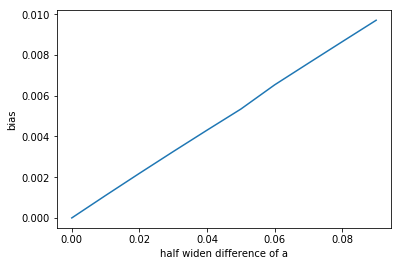

In [24]:
figure3=plt.figure(1)
diff=np.zeros(10)
half_widen=np.zeros(10)
for i in range(0,10):
    diff[i]=(result[i]-result[0])/result[0]
    half_widen[i]=0.01*i
plt.xlabel("half widen difference of a")
plt.ylabel("bias")
plt.plot(half_widen,diff)